In [1]:
import build.python.pyschedlib as sc
import scripts.schedsim as sm

import os
import shutil
import matplotlib.pyplot as plt
import polars as pl
import subprocess
from concurrent.futures import ThreadPoolExecutor
from io import StringIO

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

SCHEDVIEW = "./build/apps/schedview"
sim = sm.SchedSimRunner("./build/apps/schedsim")

In [2]:
PLATFORM = "platforms/exynos5422.json"
DIR = "alloc_tasksets"
UTILIZATION = 6.5
LITTLE_PERF_SCORE = 0.33334

targets = [round(x*0.1, 1) for x in range(1, int(LITTLE_PERF_SCORE*10)+1)];
print(targets)

[0.1, 0.2, 0.3]


# Generate the tasksets

In [3]:
if os.path.isdir(DIR):
    shutil.rmtree(DIR)

os.mkdir(DIR)

util_steps = range(1, int(UTILIZATION*10)+1, 2)
NB_JOBS = 100
NB_TASK = 40
UMAX    = 0.3 #LITTLE_PERF_SCORE - 0.13334

for i in util_steps:
    data_path = f"{DIR}/{str(i)}"
    os.mkdir(data_path)
    utilization = round(i * 0.1, 1)
    print(f"jobs = {NB_JOBS}, tasks = {NB_TASK}, umax = {UMAX}, utilization = {utilization}")
    sc.generate_tasksets(data_path, NB_JOBS, NB_TASK, utilization, UMAX, success_rate = 1.0, compression_rate = 1.0, nb_cores = 8, a_special_need=(0.0, min(targets)))

print("== finished ==")

jobs = 100, tasks = 40, umax = 0.3, utilization = 0.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.5
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.7
jobs = 100, tasks = 40, umax = 0.3, utilization = 0.9
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.5
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.7
jobs = 100, tasks = 40, umax = 0.3, utilization = 1.9
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.5
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.7
jobs = 100, tasks = 40, umax = 0.3, utilization = 2.9
jobs = 100, tasks = 40, umax = 0.3, utilization = 3.1
jobs = 100, tasks = 40, umax = 0.3, utilization = 3.3
jobs = 100, tasks = 40, umax = 0.3, utilization = 3.5
jobs = 100, tasks = 40, umax

# Simulate the tasksets

In [4]:
alloc = "smart_ass"
sched = "grub"

for target in targets:
    print(f"-> logs_{alloc}_{sched}_{target}")
    sim.simul(DIR, alloc, sched, PLATFORM, target, f"{DIR}_logs_{alloc}_{sched}_{target}")

print("== finished ==")

-> logs_smart_ass_grub_0.1
-> logs_smart_ass_grub_0.2
-> logs_smart_ass_grub_0.3
== finished ==


-> logs_smart_ass_grub_0.3


-> logs_smart_ass_grub_0.4


-> logs_smart_ass_grub_0.5


-> logs_smart_ass_grub_0.6


# Logs analysis

In [5]:
def compute_stats(logs_dir):
    args = [SCHEDVIEW, "--platform", PLATFORM, "-d", logs_dir, "--index", "--arrivals", "--rejected", "--deadlines-counts", "--cmigration", "--transitions", "--duration"]
    df_res = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
    df_res = df_res.with_columns((pl.col("file").str.extract(r"(\w+).json").cast(pl.Int32)).alias("id")).drop("file")
    df_energy = pl.DataFrame({
        "c1": [],
        "c2": []
    }, schema={"c1": pl.Float64, "c2": pl.Float64})
    for i in range(1, 101):
        args = [SCHEDVIEW, "--platform", PLATFORM, f"{logs_dir}/{i}.json", "--index", "--energy"]
        df = pl.read_csv(StringIO(subprocess.run(args, capture_output=True, text=True, check=True).stdout), separator=';')
        df = pl.DataFrame({"c1": df["energy_consumption"][0], "c2": df["energy_consumption"][1]})
        df_energy = pl.concat([df_energy, df])

    return pl.concat([df_res, df_energy], how="horizontal")

stats = {}
for target in targets:
    print(f"-> target {target}")
    stats[target] = {}
    stats_df = []
    util_steps = range(1, int(UTILIZATION * 10) + 1, 2)

    def compute_utilization_step(i):
        return compute_stats(f"{DIR}_logs_{alloc}_{sched}_{target}/{i}").with_columns(utilizations=i / 10)

    with ThreadPoolExecutor() as executor:
        stats_df = list(executor.map(compute_utilization_step, util_steps))

    stats[target] = pl.concat(stats_df).select(["utilizations", "id", pl.exclude(["utilizations", "id"])]).sort(["utilizations", "id"])

print("== finished ==")

-> target 0.1
-> target 0.2
-> target 0.3
== finished ==


In [6]:
results = {}
for target in targets:
    results[target] = (stats[target].with_columns(
        (1 - (pl.col("rejected") / pl.col("arrivals"))).alias("accepted-rates"),
        (1 - (pl.col("deadlines-counts") / (pl.col("arrivals") - pl.col("rejected")))).alias("meet-rates"),
        (pl.col("cmigration") / pl.col("transitions")).alias("migration-rates"),
        (pl.col("c1") / pl.col("duration")).alias("c1-power"),
        (pl.col("c2") / pl.col("duration")).alias("c2-power"),
        (pl.col("c1") / pl.col("duration") + pl.col("c2") / pl.col("duration")).alias("total-power")
    ).group_by("utilizations").agg(
        pl.col("accepted-rates").mean(),
        pl.col("meet-rates").mean(),
        pl.col("migration-rates").mean(),
        pl.col("c1-power").mean(),
        pl.col("c2-power").mean(),
        pl.col("total-power").mean()
    ))

energy = pl.concat([
  stats[target].select(["utilizations", "id", "c1", "c2"]).rename({"c1": f"c1-{str(target)}", "c2": f"c2-{str(target)}"}) for target in targets
], how="align")

energy_diff = energy.with_columns(
    [(pl.col(f"{clu}-{target}") - pl.col(f"{clu}-0.1")).alias(f"{clu}-{target}-diff") for target in targets for clu in ["c1", "c2"]],
).with_columns(
    [(pl.col(f"c1-{target}-diff") + pl.col(f"c2-{target}-diff")).alias(f"{target}-diff") for target in targets]
).group_by("utilizations").agg(
    pl.exclude(["utilizations", "id"]).mean()
)

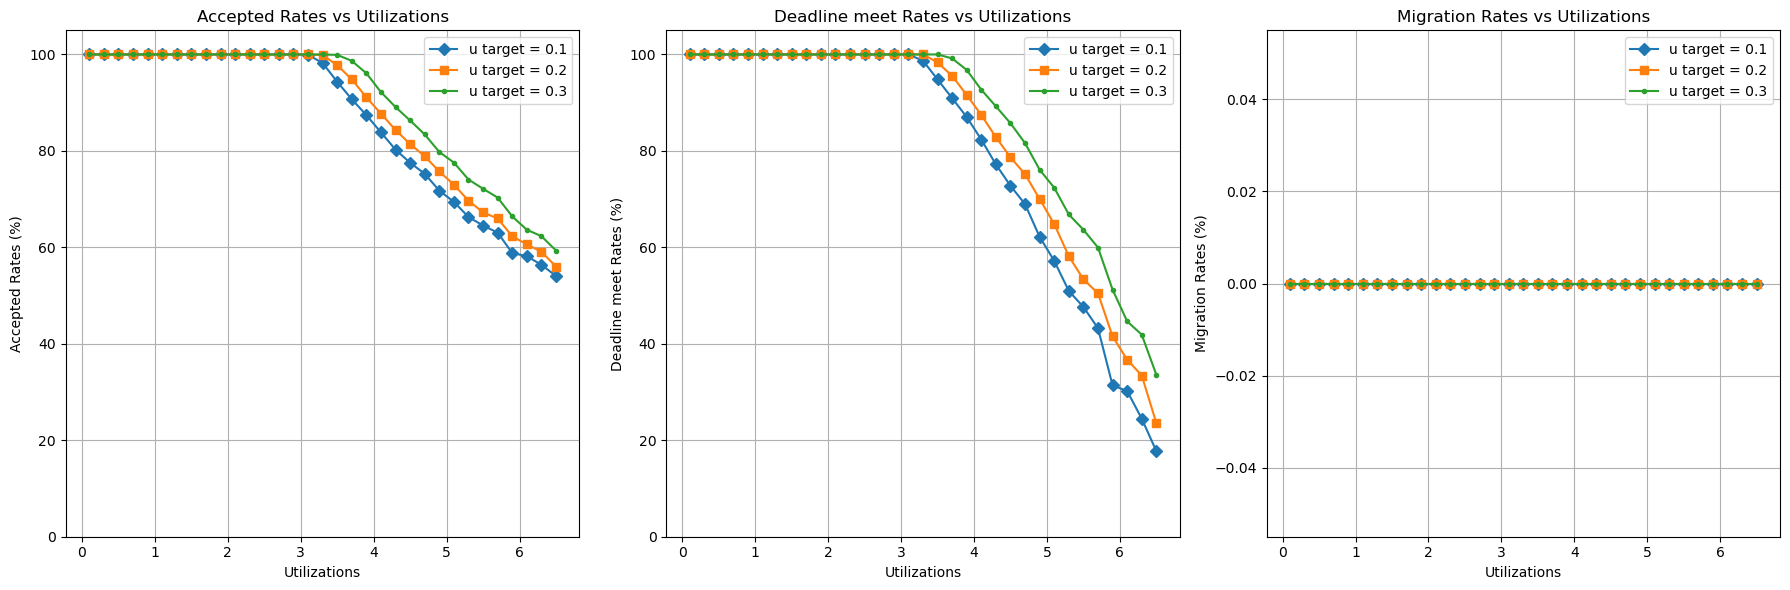

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.plot(results[0.1]["utilizations"], results[0.1]["accepted-rates"] * 100, label="u target = 0.1", marker='D')
ax1.plot(results[0.2]["utilizations"], results[0.2]["accepted-rates"] * 100, label="u target = 0.2", marker='s')
ax1.plot(results[0.3]["utilizations"], results[0.3]["accepted-rates"] * 100, label="u target = 0.3", marker='.')
ax1.set_ylim(0, 105)
ax1.set_xlabel("Utilizations")
ax1.set_ylabel("Accepted Rates (%)")
ax1.set_title("Accepted Rates vs Utilizations")
ax1.legend()
ax1.grid(True)

ax2.plot(results[0.1]["utilizations"], results[0.1]["meet-rates"] * 100, label="u target = 0.1", marker='D')
ax2.plot(results[0.2]["utilizations"], results[0.2]["meet-rates"] * 100, label="u target = 0.2", marker='s')
ax2.plot(results[0.3]["utilizations"], results[0.3]["meet-rates"] * 100, label="u target = 0.3", marker='.')
ax2.set_ylim(0, 105)
ax2.set_xlabel("Utilizations")
ax2.set_ylabel("Deadline meet Rates (%)")
ax2.set_title("Deadline meet Rates vs Utilizations")
ax2.legend()
ax2.grid(True)

ax3.plot(results[0.1]["utilizations"], results[0.1]["migration-rates"] * 100, label="u target = 0.1", marker='D')
ax3.plot(results[0.2]["utilizations"], results[0.2]["migration-rates"] * 100, label="u target = 0.2", marker='s')
ax3.plot(results[0.3]["utilizations"], results[0.3]["migration-rates"] * 100, label="u target = 0.3", marker='.')
ax3.set_xlabel("Utilizations")
ax3.set_ylabel("Migration Rates (%)")
ax3.set_title("Migration Rates vs Utilizations")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

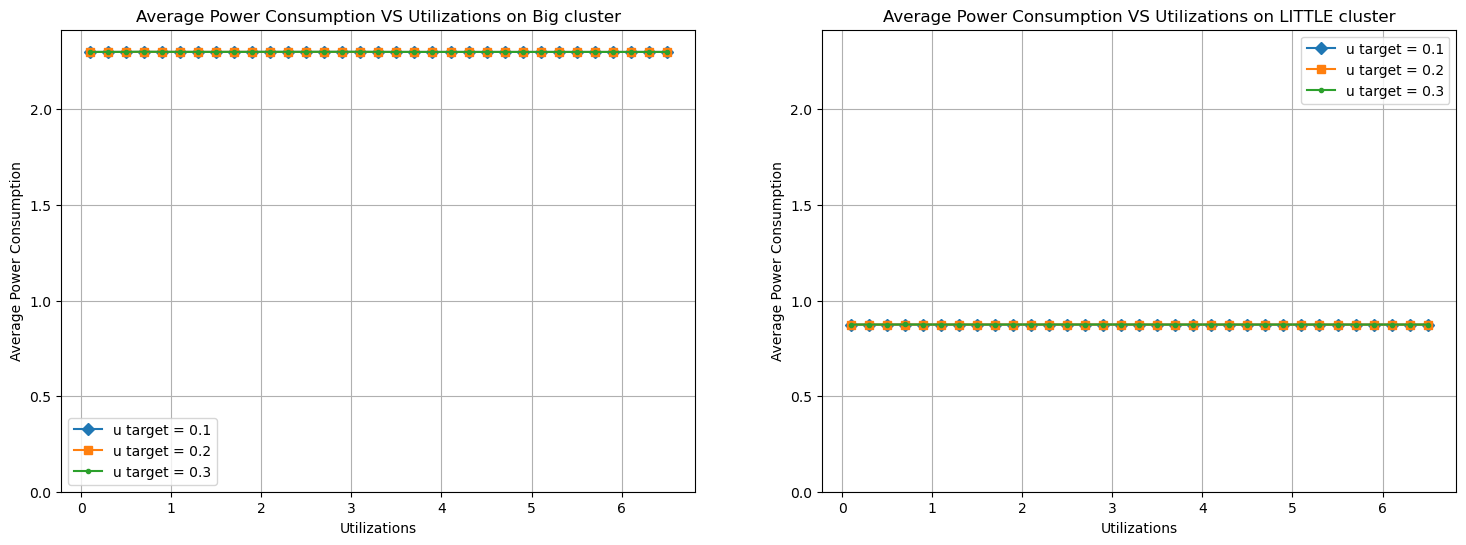

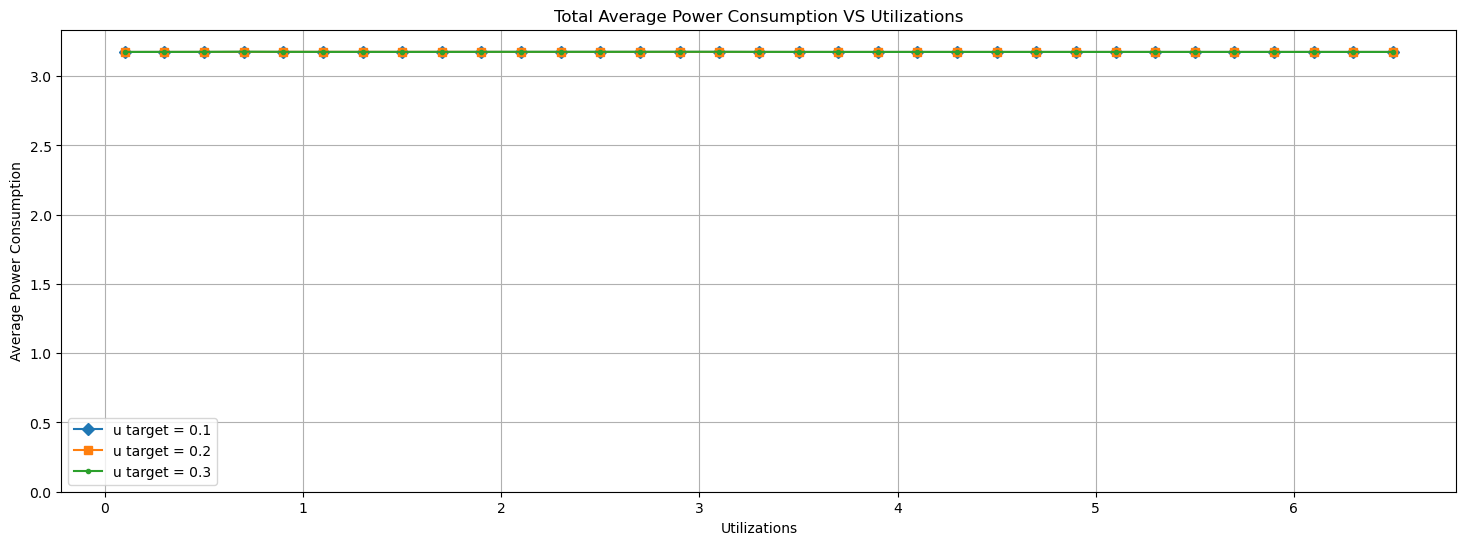

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(results[0.1]["utilizations"], results[0.1]["c1-power"], label="u target = 0.1", marker='D')
ax1.plot(results[0.2]["utilizations"], results[0.2]["c1-power"], label="u target = 0.2", marker='s')
ax1.plot(results[0.3]["utilizations"], results[0.3]["c1-power"], label="u target = 0.3", marker='.')
ax1.set_ylim(0, max([results[x]["c1-power"].max() for x in targets]) * 1.05)
ax1.set_xlabel("Utilizations")
ax1.set_ylabel("Average Power Consumption")
ax1.set_title("Average Power Consumption VS Utilizations on Big cluster")
ax1.legend()
ax1.grid(True)
ax2.plot(results[0.1]["utilizations"], results[0.1]["c2-power"], label="u target = 0.1", marker='D')
ax2.plot(results[0.2]["utilizations"], results[0.2]["c2-power"], label="u target = 0.2", marker='s')
ax2.plot(results[0.3]["utilizations"], results[0.3]["c2-power"], label="u target = 0.3", marker='.')
ax2.set_ylim(0, max([results[x]["c1-power"].max() for x in targets]) * 1.05)
ax2.set_xlabel("Utilizations")
ax2.set_ylabel("Average Power Consumption")
ax2.set_title("Average Power Consumption VS Utilizations on LITTLE cluster")
ax2.legend()
ax2.grid(True)
fig, (ax3) = plt.subplots(1, 1, figsize=(18, 6))
ax3.plot(results[0.1]["utilizations"], results[0.1]["total-power"], label="u target = 0.1", marker='D')
ax3.plot(results[0.2]["utilizations"], results[0.2]["total-power"], label="u target = 0.2", marker='s')
ax3.plot(results[0.3]["utilizations"], results[0.3]["total-power"], label="u target = 0.3", marker='.')
ax3.set_ylim(0, max([results[x]["total-power"].max() for x in targets]) * 1.05)
ax3.set_xlabel("Utilizations")
ax3.set_ylabel("Average Power Consumption")
ax3.set_title("Total Average Power Consumption VS Utilizations")
ax3.legend()
ax3.grid(True)

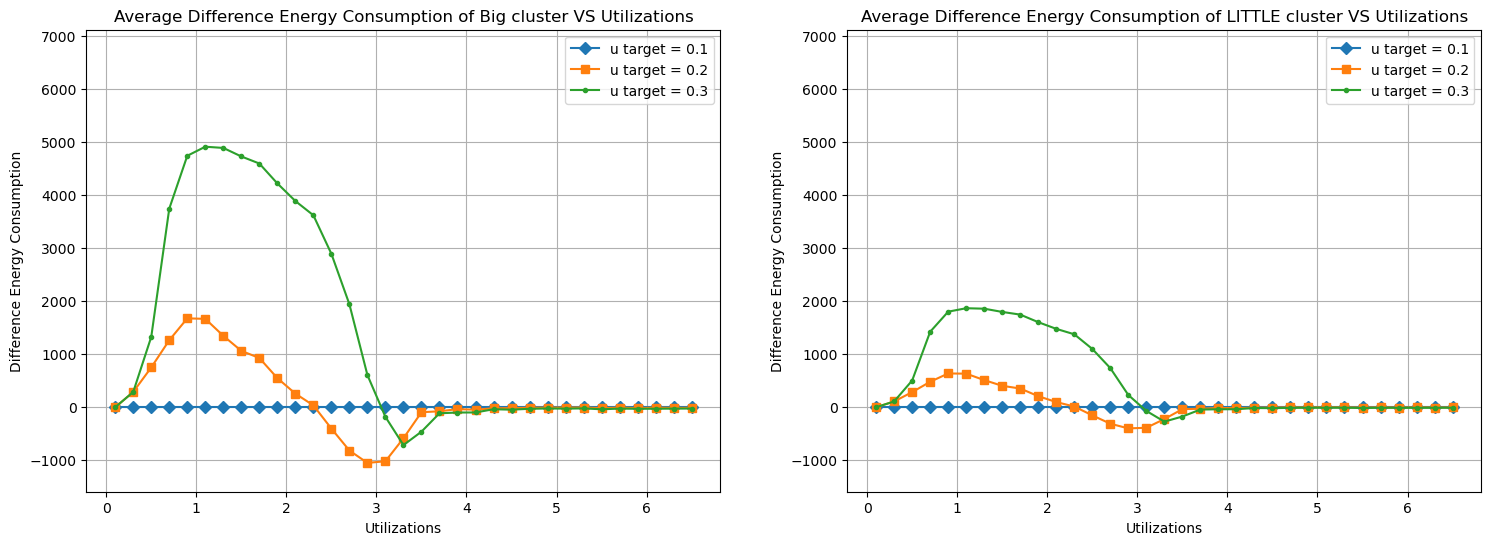

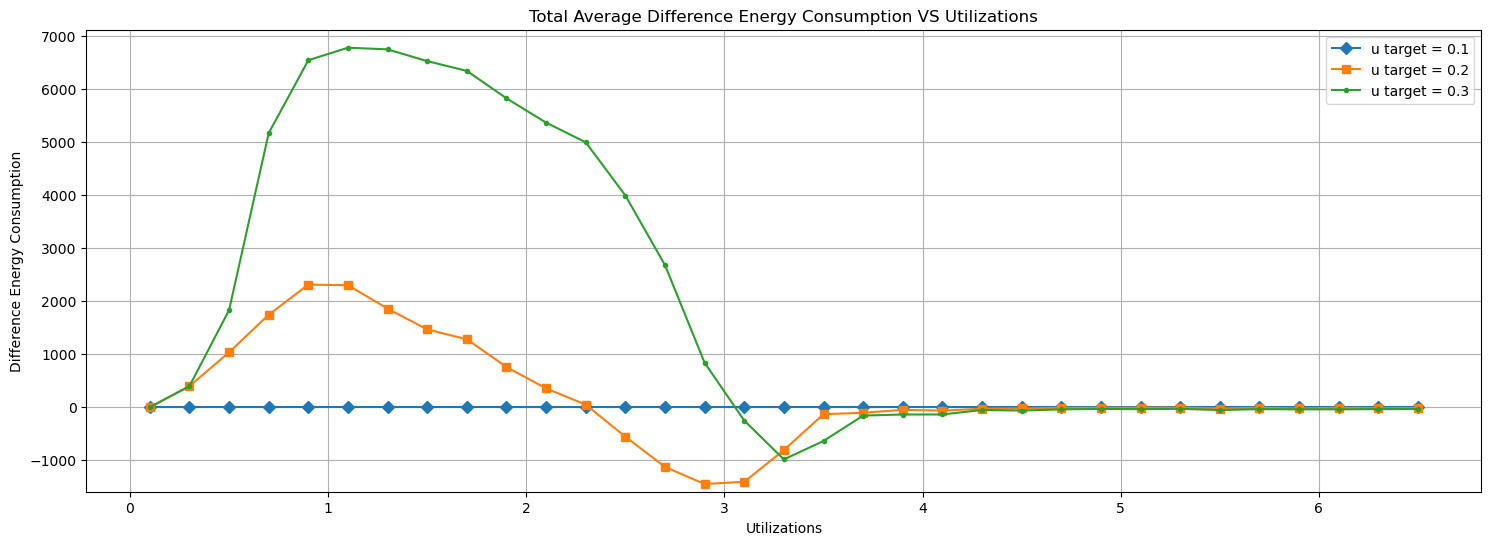

In [13]:
min_y = min(energy_diff["0.2-diff"].min(), energy_diff["0.3-diff"].min()) * 1.10
max_y = max(energy_diff["0.2-diff"].max(), energy_diff["0.3-diff"].max()) * 1.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(energy_diff["utilizations"], energy_diff["c1-0.1-diff"], label="u target = 0.1", marker='D')
ax1.plot(energy_diff["utilizations"], energy_diff["c1-0.2-diff"], label="u target = 0.2", marker='s')
ax1.plot(energy_diff["utilizations"], energy_diff["c1-0.3-diff"], label="u target = 0.3", marker='.')
ax1.set_xlabel("Utilizations")
ax1.set_ylabel("Difference Energy Consumption")
ax1.set_title("Average Difference Energy Consumption of Big cluster VS Utilizations")
ax1.set_ylim(min_y, max_y)
ax1.legend()
ax1.grid(True)
ax2.plot(energy_diff["utilizations"], energy_diff["c2-0.1-diff"], label="u target = 0.1", marker='D')
ax2.plot(energy_diff["utilizations"], energy_diff["c2-0.2-diff"], label="u target = 0.2", marker='s')
ax2.plot(energy_diff["utilizations"], energy_diff["c2-0.3-diff"], label="u target = 0.3", marker='.')
ax2.set_xlabel("Utilizations")
ax2.set_ylabel("Difference Energy Consumption")
ax2.set_title("Average Difference Energy Consumption of LITTLE cluster VS Utilizations")
ax2.set_ylim(min_y, max_y)
ax2.legend()
ax2.grid(True)
fig, (ax3) = plt.subplots(1, 1, figsize=(18, 6))
ax3.plot(energy_diff["utilizations"], energy_diff["0.1-diff"], label="u target = 0.1", marker='D')
ax3.plot(energy_diff["utilizations"], energy_diff["0.2-diff"], label="u target = 0.2", marker='s')
ax3.plot(energy_diff["utilizations"], energy_diff["0.3-diff"], label="u target = 0.3", marker='.')
ax3.set_xlabel("Utilizations")
ax3.set_ylabel("Difference Energy Consumption")
ax3.set_title("Total Average Difference Energy Consumption VS Utilizations")
ax3.set_ylim(min_y, max_y)
ax3.legend()
ax3.grid(True)